Example: Using iGP models with the first markovian approximation to track a mosquito trajectory

In [191]:
import numpy as np
np.random.seed(0)

In [192]:
# Import ground truth coordinates from csv file

import pandas as pd

file_path = 'mosquito_coordinates.csv'
df = pd.read_csv(file_path)
gt_x, gt_y = np.array(df['x']), np.array(df['y'])

In [193]:
# Add Gaussian noise to simulate noisy measurements
noise_var = 0.005
noise_x = np.random.normal(0, noise_var, len(gt_x))
noise_y = np.random.normal(0, noise_var, len(gt_y))

meas_x = gt_x + noise_x
meas_y = gt_y + noise_y

In [194]:
# Initialise transition model (Choose iSE or iiSE)

from stonesoup.models.transition.linear import (
    CombinedLinearGaussianTransitionModel,
    IntegratedGP,
    TwiceIntegratedGP, 
    DynamicsInformedIntegratedGP,
    DynamicsInformedTwiceIntegratedGP
)

window_size = 10
length_scale = 0.05
kernel_variance = 0.002

transition_model_iSE = CombinedLinearGaussianTransitionModel([IntegratedGP(markov_approx=1, window_size=window_size, length_scale=length_scale, kernel_variance=kernel_variance),
                                                              IntegratedGP(markov_approx=1, window_size=window_size, length_scale=length_scale, kernel_variance=kernel_variance)])

transition_model_iiSE = CombinedLinearGaussianTransitionModel([TwiceIntegratedGP(window_size=window_size, length_scale=length_scale, kernel_variance=kernel_variance),
                                                               TwiceIntegratedGP(window_size=window_size, length_scale=length_scale, kernel_variance=kernel_variance)])

dynamics_coeff = -0.2
gp_coeff = 0.5

transition_model_iDSE = CombinedLinearGaussianTransitionModel([DynamicsInformedIntegratedGP(markov_approx=1, window_size=window_size, length_scale=length_scale, kernel_variance=kernel_variance, dynamics_coeff=dynamics_coeff, gp_coeff=gp_coeff),
                                                              DynamicsInformedIntegratedGP(markov_approx=1, window_size=window_size, length_scale=length_scale, kernel_variance=kernel_variance, dynamics_coeff=dynamics_coeff, gp_coeff=gp_coeff)])

transition_model_iiDSE = CombinedLinearGaussianTransitionModel([DynamicsInformedTwiceIntegratedGP(window_size=window_size, length_scale=length_scale, kernel_variance=kernel_variance, dynamics_coeff=dynamics_coeff, gp_coeff=gp_coeff),
                                                               DynamicsInformedTwiceIntegratedGP(window_size=window_size, length_scale=length_scale, kernel_variance=kernel_variance, dynamics_coeff=dynamics_coeff, gp_coeff=gp_coeff)])

In [195]:
# Initialise measurement models

from stonesoup.models.measurement.linear import LinearGaussian
from stonesoup.base import Property

# Define class to override matrix method to include augmented state
class LinearGaussianAugmented(LinearGaussian):
    "Measurement = 1st elem of state vector + 1st augmented state"
    num_aug_states: int = Property()

    @property
    def ndim_meas(self):
        return 2
    
    def matrix(self, **kwargs):
        ndim = self.ndim_state // 2
        model_matrix = np.zeros((self.ndim_meas, self.ndim_state))
        model_matrix[0, 0], model_matrix[0, ndim-self.num_aug_states] = 1, 1
        model_matrix[1, ndim], model_matrix[1, ndim*2-self.num_aug_states] = 1, 1
        return model_matrix
    
measurement_model_iSE = LinearGaussianAugmented(
                            ndim_state=transition_model_iSE.ndim_state,
                            num_aug_states=1,
                            mapping=(),  # placeholder, not needed as we construct the matrix directly
                            noise_covar=np.array([[noise_var, 0],
                                                  [0, noise_var]])
                        )

measurement_model_iiSE = LinearGaussianAugmented(
                            ndim_state=transition_model_iiSE.ndim_state,
                            num_aug_states=2,
                            mapping=(),  # placeholder, not needed as we construct the matrix directly
                            noise_covar=np.array([[noise_var, 0],
                                                  [0, noise_var]])
                        )

In [ ]:
# Select your transition and measurement model here
# use measurement_model_iSE with iDSE; measurement_model_iiSE with iiDSE
transition_model = transition_model_iSE
measurement_model = measurement_model_iSE

ndim = transition_model.ndim_state // 2  # state vector in one dimension
num_aug_states = ndim - window_size

In [197]:
# Generate ground truth path and measurements for tracking in Stone Soup

from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.types.detection import Detection

from datetime import timedelta, datetime

truth_path = GroundTruthPath()
start_time = datetime.now()
time_interval = timedelta(seconds=0.1)

prior_x, prior_y = gt_x[0], gt_y[0]
gt_zero_mean_x = gt_x - prior_x
gt_zero_mean_y = gt_y - prior_y

# Ground truth path
for t in range(len(gt_x)):
    state_vector = np.zeros(ndim * 2)
    state_vector[0], state_vector[ndim] = gt_zero_mean_x[t], gt_zero_mean_y[t]
    state_vector[ndim - num_aug_states], state_vector[-num_aug_states] = prior_x, prior_y
    truth_path.append(GroundTruthState(state_vector, timestamp=start_time + t * time_interval))

# Measurements as stone soup detection objects
measurements = []
for x, y, truth in zip(meas_x, meas_y, truth_path):
    measurement = Detection([x, y], timestamp=truth.timestamp, measurement_model=measurement_model)
    measurements.append(measurement)

In [198]:
# Tracking with Kalman filter

from stonesoup.types.state import GaussianState
from stonesoup.types.track import Track

# Track initialisation

# Create prior state vector [0, ..., 0, prior_x, 0, ..., 0, prior_y]
prior_state_vector = np.zeros(ndim * 2)
prior_state_vector[ndim - num_aug_states], prior_state_vector[-num_aug_states] = prior_x, prior_y
prior_covar = np.zeros((ndim*2, ndim*2))
prior_covar[0, 0] = prior_covar[ndim, ndim] = noise_var
prior_covar[ndim - num_aug_states, ndim - num_aug_states] = prior_covar[-num_aug_states, -num_aug_states] = noise_var

track = Track(GaussianState(prior_state_vector, prior_covar, timestamp=start_time))


In [199]:
# Define Kalman Predictor and Updater

from stonesoup.predictor.kalman import KalmanPredictor
from stonesoup.predictor.gaussianprocess import GPPredictorWrapper
from stonesoup.updater.kalman import KalmanUpdater

predictor = GPPredictorWrapper(KalmanPredictor(transition_model))
updater = KalmanUpdater(measurement_model)

In [200]:
# Run tracking

from stonesoup.types.hypothesis import SingleHypothesis

for measurement in measurements[1:]:
    # Prediction step
    predicted_state = predictor.predict(track, timestamp=measurement.timestamp)

    # Update step
    updated_state = updater.update(SingleHypothesis(predicted_state, measurement))

    # Store updated state
    track.append(updated_state)

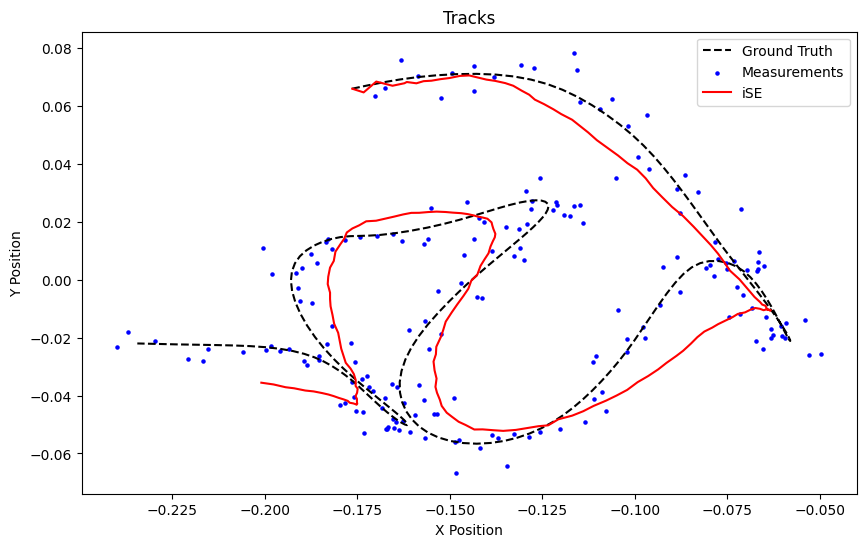

In [201]:
# plot tracks

import matplotlib.pyplot as plt

# Extract (x, y) coordinates from track
pos = [measurement_model.function(state) for state in track]
x_vals = []
y_vals = []
for state in pos:
    x_vals.append(state[0])
    y_vals.append(state[1])

# Plot ground truth and tracks
plt.figure(figsize=(10, 6))
plt.plot(gt_x, gt_y, label="Ground Truth", linestyle="dashed", color="black")
plt.scatter(meas_x, meas_y, label="Measurements", color="blue", s=5)

plt.plot(x_vals, y_vals, label="iSE", color="red")

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.title("Tracks")
plt.show()


In [202]:
from stonesoup.plotter import AnimatedPlotterly

from copy import deepcopy

timesteps = [start_time + time_interval * i for i in range(len(gt_x) + window_size)]

# Add augmented mean to state vector for plotter
truth_path_aug = GroundTruthPath()
track_aug = Track()

for truth, state in zip(truth_path, track):
    truth_aug = deepcopy(truth)
    state_aug = deepcopy(state)
    truth_aug.state_vector[0] += truth_aug.state_vector[ndim - num_aug_states]
    truth_aug.state_vector[ndim] += truth_aug.state_vector[-num_aug_states]
    state_aug.state_vector[0] += state_aug.state_vector[ndim - num_aug_states]
    state_aug.state_vector[ndim] += state_aug.state_vector[-num_aug_states]
    truth_path_aug.append(truth_aug)
    track_aug.append(state_aug)

plotter = AnimatedPlotterly(timesteps, tail_length=1)
plotter.plot_ground_truths(truth_path_aug, [0, ndim])
plotter.plot_measurements(measurements, [0, 1], convert_measurements=False)
plotter.plot_tracks(track_aug, [0, ndim])
plotter.fig